In [ ]:

import pickle
import numpy as np
import os
from keras.callbacks import LearningRateScheduler,EarlyStopping
from keras.layers import Dense,Flatten,MaxPooling2D,Conv2D
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

In [ ]:
base_dir="/content/drive/MyDrive/dataset/osa_data"

In [ ]:
# DEEP LEARNING MODELS NEED TO VECTORS OR MATRIX WITH SAME SIZE
# R-R INTERVALS DONT HAVE SAME SIZE, SO WE NEED TO INTERPOLATE VECTORS TO GET VECTORS WITH SAME SIZE.
# BASED ON OUR EXPERIENCE INTERPOLATION IN 3 HZ BETTER AND ACCURATE.
ir = 3 # INTERPOLATION RATE(3HZ)
time_range= 60 # 60-s INTERVALS OF ECG SIGNALS
weight=1e-3 #  WEIGHT L2 FOR REGULARIZATION(AVODING OVERFITTING PARAMETER)
#------------------------------------------------------------------------------
# NORMALIZATION:
# DEEP LEARNING AND EVEN NEURAL NETWORKS INPUT SHOULD BE NORMALIZED:
# MIN-MAX METHOD APPLIED FOR SCALING:(Array-min(Array))/(max(Array)-min(Array))
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [ ]:
# FIRSTLY WE PRE-PROCESSED OUR DATA IN "apnea-ecg.pkl" FILE
# IN PRE-PROCESSING SECTION WE EXTRACT R-R INTERVALS AND R-PEAK AMPLITUDES
# IN THIS PART WE LOAD THIS DATA AND INTERPOLATE AND CONCATE FOR FEEDING TO NETWORKS
def load_data():
    tm = np.arange(0, (time_range), step=(1) / float(ir)) # TIME METRIC FOR INTERPOLATION
    # LOAD AND INTERPOLATE R-R INTERVALS AND R-PEAK AMPLITUDES
    with open(os.path.join( base_dir,"apnea-ecg.pkl"), 'rb') as f:
        apnea_ecg = pickle.load(f)

    x = []
    X, Y = apnea_ecg["o_train"], apnea_ecg["y_train"]
    for i in range(len(X)):
        (rri_tm, rri_signal), (amp_tm, amp_signal) = X[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        amp_interp_signal = splev(tm, splrep(amp_tm, scaler(amp_signal), k=3), ext=1)
        x.append([rri_interp_signal, amp_interp_signal])
    x = np.array(x, dtype="float32")


    x = np.expand_dims(x,1)
    x_final=np.array(x, dtype="float32").transpose((0,3,1,2))


    return x_final, Y

In [ ]:
# CREAT DEEP LEARNING MODEL
def create_model(weight=1e-3):

    model= Sequential()
    model.add(Conv2D(64, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight),input_shape=(180,1,2)))
    model.add(Conv2D(64, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Conv2D(128, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(128, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Conv2D(256, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(256, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(256, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(256, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(MaxPooling2D(pool_size=(2,1)))
    model.add(Conv2D(512, kernel_size=(3,1), strides=1, padding="valid", activation="relu", kernel_initializer="he_normal",
                kernel_regularizer=l2(weight), bias_regularizer=l2(weight)))
    model.add(Flatten())
    model.add(Dense(167, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    return model


In [ ]:
# Define learning rate schedule for preventing overfitting in deep learning methods:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [ ]:
# Compile and evaluate model:
if __name__ == "__main__":
    # loading Data:
    X, Y = load_data()
    # we have labels(Y) in a binary way 0 for normal and 1 for apnea patients
    # we want to classify data into 2-class so we changed y in a categorical way:
    Y = tf.keras.utils.to_categorical(Y, num_classes=2)
    # we used k-fold cross-validation for more reliable experiments:
    kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=7)
    cvscores = []
    ACC=[]
    SN=[]
    SP=[]
    F2=[]
    # separate train& test and then compile model
    for train, test in kfold.split(X, Y.argmax(1)):
     model = create_model()


     model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
     # define callback for early stopping:
     lr_scheduler = LearningRateScheduler(lr_schedule)
     callback1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     #10% of Data used for validation:
     X1,x_val,Y1,y_val=train_test_split(X[train],Y[train],test_size=0.10)

     history = model.fit(X1, Y1, batch_size=128, epochs=100, validation_data=(x_val, y_val),
                        callbacks=[callback1,lr_scheduler])

     model.save(os.path.join("model.VGG19.h5"))

Learning rate:  0.0010000000474974513
Epoch 1/100
94/94 [==============================] - 27s 58ms/step - loss: 5.5891 - accuracy: 0.6150 - val_loss: 3.7693 - val_accuracy: 0.6836 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
94/94 [==============================] - 3s 27ms/step - loss: 3.3226 - accuracy: 0.6781 - val_loss: 2.9518 - val_accuracy: 0.6971 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 3/100
94/94 [==============================] - 3s 27ms/step - loss: 2.7613 - accuracy: 0.6527 - val_loss: 2.6393 - val_accuracy: 0.5969 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 4/100
94/94 [==============================] - 2s 26ms/step - loss: 2.3778 - accuracy: 0.6884 - val_loss: 2.2147 - val_accuracy: 0.7105 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 5/100
94/94 [==============================] - 2s 26ms/step - loss: 2.1028 - accuracy: 0.7124 - val_loss: 1.9611 - val_accuracy: 0.7300 - lr: 0.0010
Learning rate:  0.0010000000474974

In [ ]:
     loss, accuracy = model.evaluate(X[test], Y[test])

     y_score = model.predict(X[test])

     y_predict= np.argmax(y_score, axis=-1)
     y_training = np.argmax(Y[test], axis=-1)
     # Confusion matrix:
     from sklearn.metrics import confusion_matrix
     from sklearn.metrics import f1_score
     C = confusion_matrix(y_training, y_predict, labels=(1, 0))
     TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
     acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
     f2=f1_score(y_training, y_predict)

     ACC.append(acc * 100)
     SN.append(sn * 100)
     SP.append(sp * 100)
     F2.append(f2 * 100)

105/105 [==============================] - 0s 3ms/step


42/42 [==============================] - 0s 11ms/step - loss: 0.4834 - accuracy: 0.8369
Test loss:  0.48340660333633423
Accuracy:  0.8369483947753906
42/42 [==============================] - 0s 3ms/step


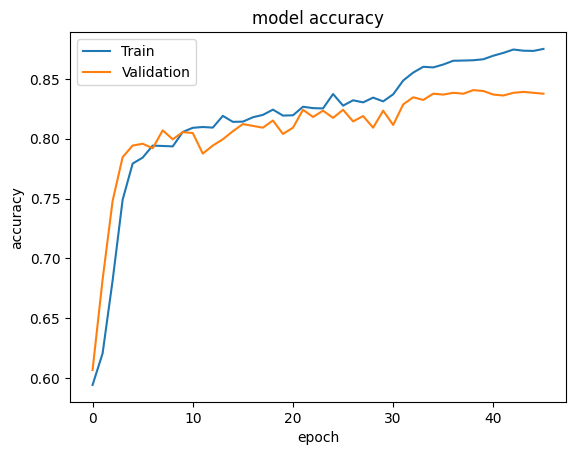

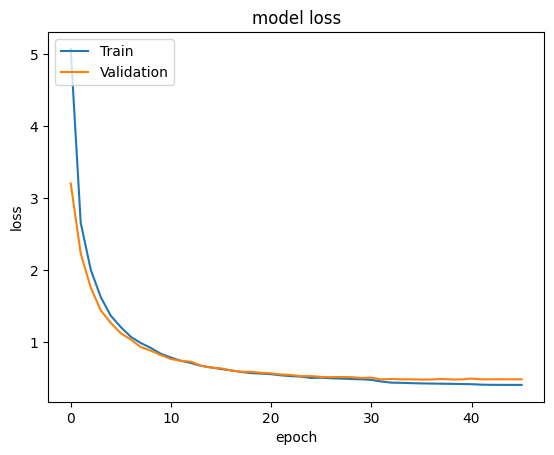

In [ ]:
    loss, accuracy = model.evaluate(x_val, y_val) # test the model
    print("Test loss: ", loss)
    print("Accuracy: ", accuracy)

    # save prediction score
    y_score = model.predict(x_val)
    #output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
    #output.to_csv(os.path.join("base_dir", "LeNet.csv"), index=False)
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()